# Playing Cards Detection

In [1]:
import os
import yaml
import random
import opendatasets as od
import cv2 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from ultralytics import YOLO
%matplotlib inline

In [2]:
# set working directory

HOME = os.getcwd()
print(HOME)

c:\Users\marcu\OneDrive\Dokumenter\Programming\Python\Projects\Playing_Cards_Recognition


## 1. Downloading Dataset

Here i had to follow a few steps to download the dataset from kaggle: 

* 1. Go to https://kaggle.com/me/account (sign in if required).
* 2. Scroll down to the "API" section and click "Create New API Token". This will download a file kaggle.json with the following contents: `{"username":"YOUR_KAGGLE_USERNAME","key":"YOUR_KAGGLE_KEY"}`
* 3. When you run opendatsets.download, you will be asked to enter your username & Kaggle API, which you can get from the file downloaded in step 2.

<div style="background-color: #2d2d2d; border-left: 5px solid #f39c12; padding: 10px; color: white;">
  💡 <strong>Tip:</strong> Note that you need to download the kaggle.json file only once. You can also place the kaggle.json file in the same directory as the Jupyter notebook, and the credentials will be read automatically.
</div>


In [3]:
# downloading dataset with opendatasets from kaggle

od.download("https://www.kaggle.com/datasets/andy8744/playing-cards-object-detection-dataset")

Skipping, found downloaded files in ".\playing-cards-object-detection-dataset" (use force=True to force download)


In [4]:
# define train, valid, test directories

train_images = os.path.join(HOME, "playing-cards-object-detection-dataset", "train", "images")
train_labels = os.path.join(HOME, "playing-cards-object-detection-dataset", "train", "labels")

valid_images = os.path.join(HOME, "playing-cards-object-detection-dataset", "valid", "images")
valid_labels = os.path.join(HOME, "playing-cards-object-detection-dataset", "valid", "labels")

test_images = os.path.join(HOME, "playing-cards-object-detection-dataset", "test", "images")
test_labels = os.path.join(HOME, "playing-cards-object-detection-dataset", "test", "labels")

yaml_path = os.path.join(HOME, "playing-cards-object-detection-dataset", "data.yaml")

In [5]:
print(train_images)
print(valid_images)
print(test_images)

c:\Users\marcu\OneDrive\Dokumenter\Programming\Python\Projects\Playing_Cards_Recognition\playing-cards-object-detection-dataset\train\images
c:\Users\marcu\OneDrive\Dokumenter\Programming\Python\Projects\Playing_Cards_Recognition\playing-cards-object-detection-dataset\valid\images
c:\Users\marcu\OneDrive\Dokumenter\Programming\Python\Projects\Playing_Cards_Recognition\playing-cards-object-detection-dataset\test\images


In [6]:
yaml_path

'c:\\Users\\marcu\\OneDrive\\Dokumenter\\Programming\\Python\\Projects\\Playing_Cards_Recognition\\playing-cards-object-detection-dataset\\data.yaml'

In [7]:
def read_class_from_yaml(file_path):
    with open(file_path, "r") as file:
        config = yaml.safe_load(file)
    return config["names"]

In [8]:
classes = read_class_from_yaml(yaml_path)
print(classes)
print(type(classes))

['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs']
<class 'list'>


In [9]:
# define labels

index2label = {index: label for index, label in enumerate(classes)}
label2index = {label: index for index, label in index2label.items()}

print(f"Index to Label Mapping: {index2label}")
print(f"Label to Index Mapping: {label2index}")

Index to Label Mapping: {0: '10c', 1: '10d', 2: '10h', 3: '10s', 4: '2c', 5: '2d', 6: '2h', 7: '2s', 8: '3c', 9: '3d', 10: '3h', 11: '3s', 12: '4c', 13: '4d', 14: '4h', 15: '4s', 16: '5c', 17: '5d', 18: '5h', 19: '5s', 20: '6c', 21: '6d', 22: '6h', 23: '6s', 24: '7c', 25: '7d', 26: '7h', 27: '7s', 28: '8c', 29: '8d', 30: '8h', 31: '8s', 32: '9c', 33: '9d', 34: '9h', 35: '9s', 36: 'Ac', 37: 'Ad', 38: 'Ah', 39: 'As', 40: 'Jc', 41: 'Jd', 42: 'Jh', 43: 'Js', 44: 'Kc', 45: 'Kd', 46: 'Kh', 47: 'Ks', 48: 'Qc', 49: 'Qd', 50: 'Qh', 51: 'Qs'}
Label to Index Mapping: {'10c': 0, '10d': 1, '10h': 2, '10s': 3, '2c': 4, '2d': 5, '2h': 6, '2s': 7, '3c': 8, '3d': 9, '3h': 10, '3s': 11, '4c': 12, '4d': 13, '4h': 14, '4s': 15, '5c': 16, '5d': 17, '5h': 18, '5s': 19, '6c': 20, '6d': 21, '6h': 22, '6s': 23, '7c': 24, '7d': 25, '7h': 26, '7s': 27, '8c': 28, '8d': 29, '8h': 30, '8s': 31, '9c': 32, '9d': 33, '9h': 34, '9s': 35, 'Ac': 36, 'Ad': 37, 'Ah': 38, 'As': 39, 'Jc': 40, 'Jd': 41, 'Jh': 42, 'Js': 43, 'K

## 2. Explore Dataset

In [10]:
my_list = [4, 33, 86, 102, 5555, 111]

random.sample(my_list, 3)

[86, 4, 111]

In [11]:
def visualize_images_with_annotation_boxes(image_dir, label_dir, n_images=12):
    image_files = sorted(os.listdir(image_dir))

    sample_image_files = random.sample(image_files, n_images)

    plot_ncols = 3
    plot_nrows =  (n_images + plot_ncols - 1) // plot_ncols

    fig, axs = plt.subplots(plot_nrows, plot_ncols, figsize=(15, 20))
    
    axs = axs.flatten()

    for i, image_file in enumerate(sample_image_files):
        
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_file_name = os.path.splitext(image_file)[0]
        label_path = os.path.join(label_dir, label_file_name + ".txt")

        with open(label_path, "r") as file:
            for label in file:
                class_id, x_center, y_center, width, height = map(float, label.split())
                h, w, _ = image.shape
                x_min = int((x_center - width/2) * w)
                x_max = int((x_center + width/2) * w)
                y_min = int((y_center - height/2) * h)
                y_max = int((y_center + height/2) * h)
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 255), 2)
                cv2.putText(image, index2label[int(class_id)], (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

        axs[i].imshow(image)
    
    for ax in axs: ax.axis("off")
    plt.tight_layout()
    plt.show()

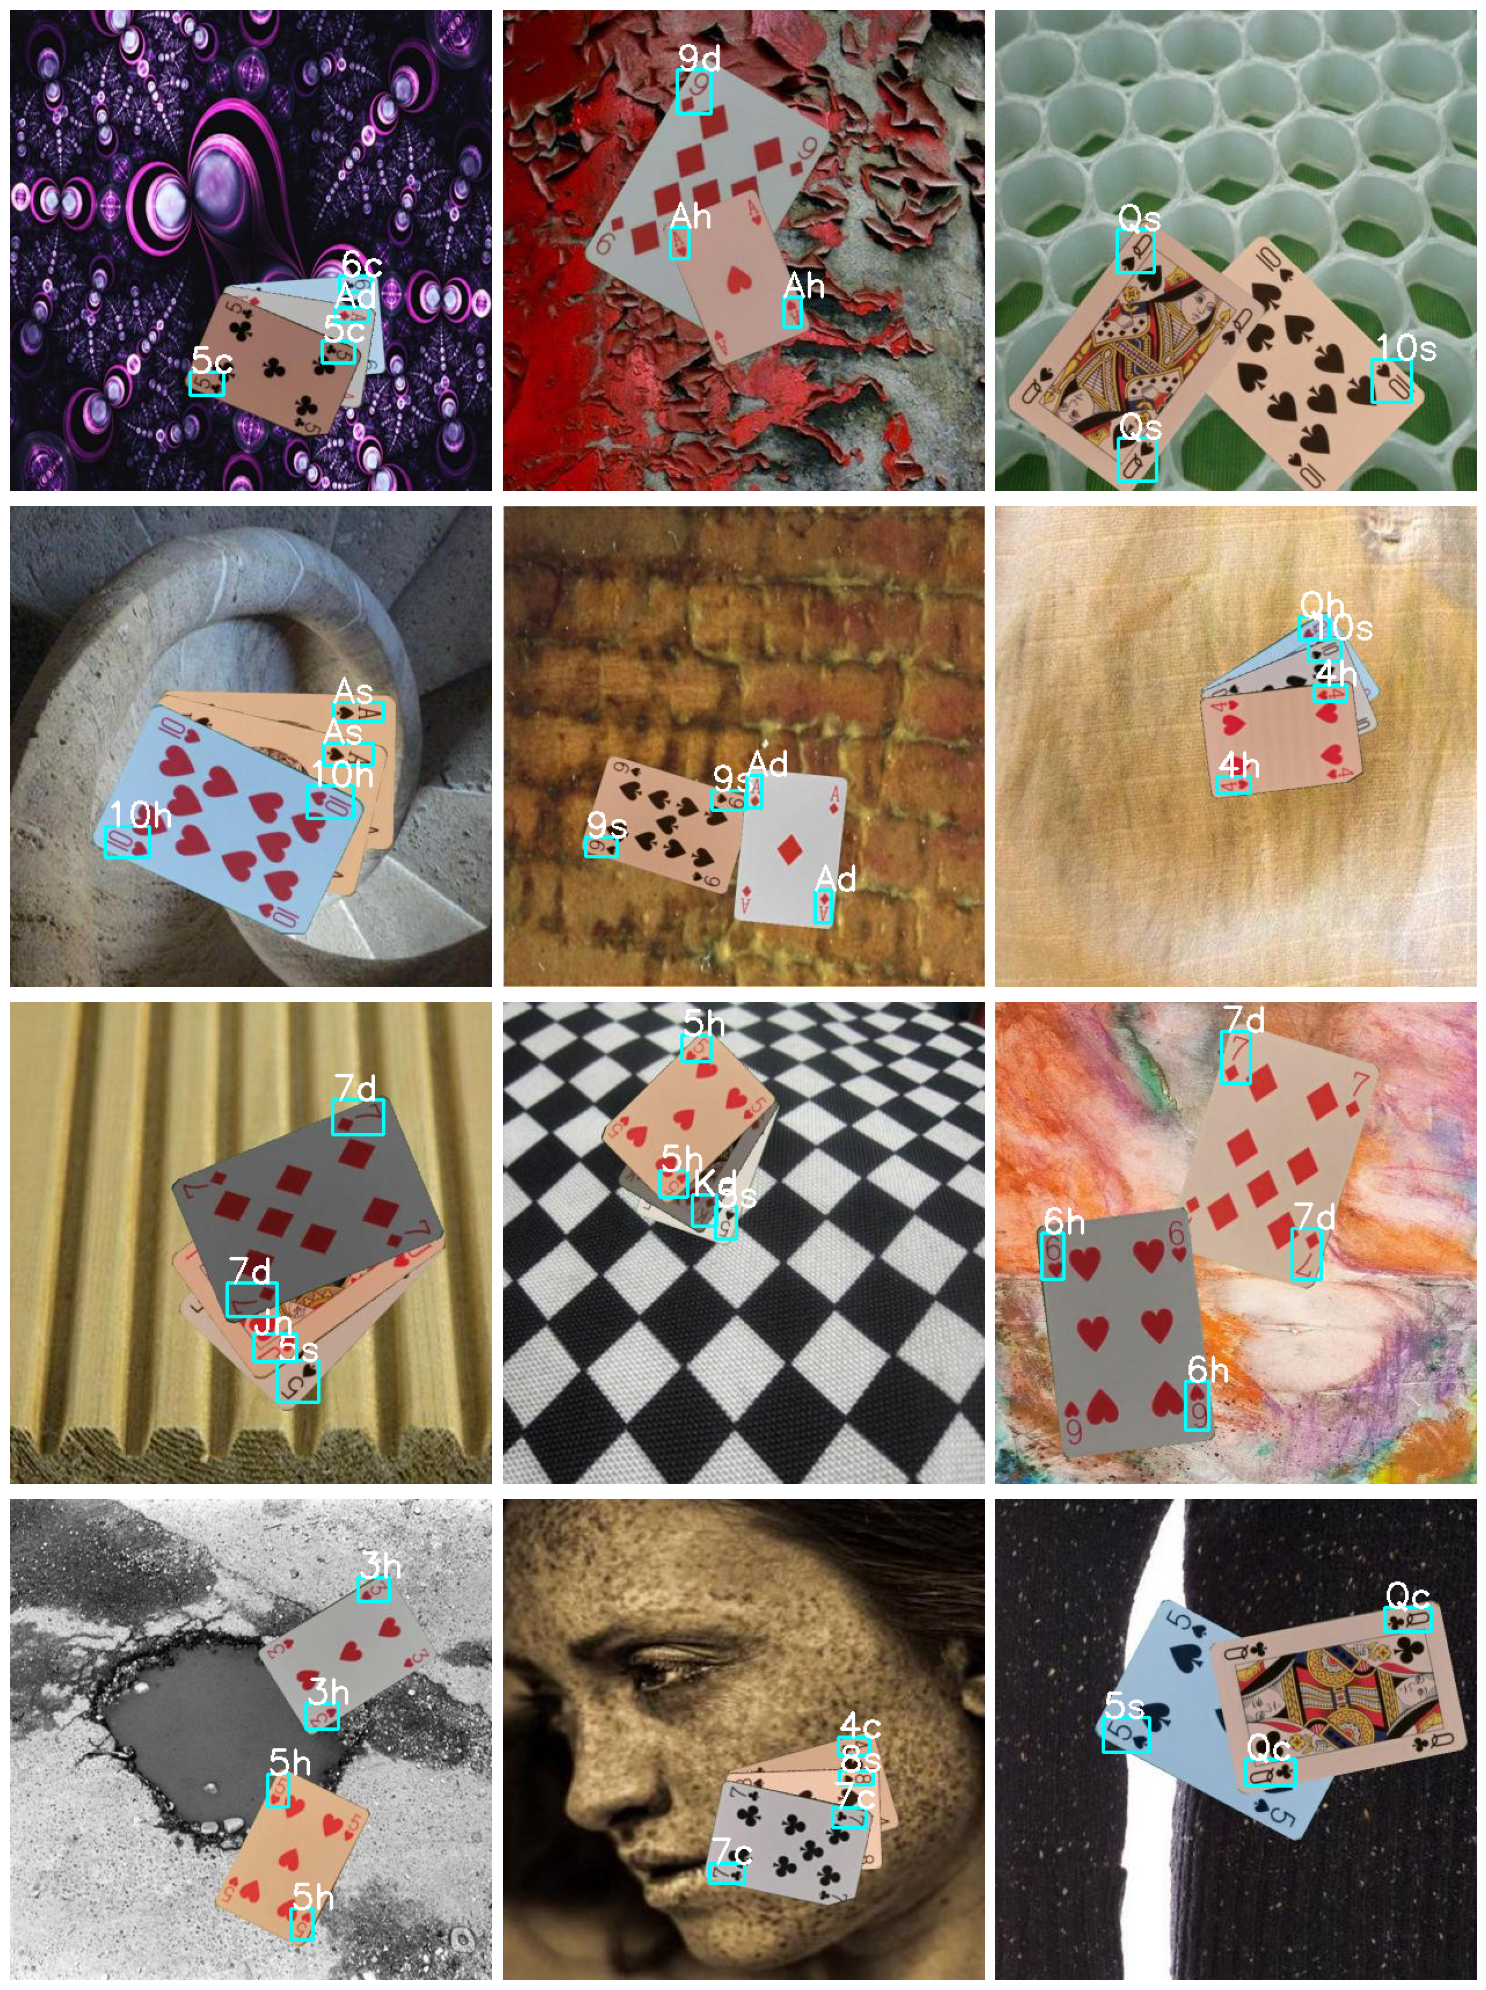

In [12]:
visualize_images_with_annotation_boxes(train_images, train_labels)

In [13]:
# read an image by path
image_path = os.path.join(train_images, os.listdir(train_images)[-1])
image = cv2.imread(image_path)

# get the size of the image
height, width, channels = image.shape
print(f"The image hase dimensions {width}x{height} aand {channels} channels")

The image hase dimensions 416x416 aand 3 channels


## 3. Training

In [14]:
torch.cuda.is_available()

True

In [15]:
# load a pretrained nano model
model = YOLO("yolov8n.pt")

torch.cuda.empty_cache()

results = model.train(
    data = yaml_path,
    epochs = 25,
    imgsz = (height, width, channels),
    seed = 42,
    batch = 8,
    workers = 4,
    patience = 5,
    name = "yolov8n_custom",
    device = "cuda"
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 66.2MB/s]


Ultralytics 8.3.82  Python-3.10.16 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=c:\Users\marcu\OneDrive\Dokumenter\Programming\Python\Projects\Playing_Cards_Recognition\playing-cards-object-detection-dataset\data.yaml, epochs=25, time=None, patience=5, batch=8, imgsz=(416, 416, 3), save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=yolov8n_custom, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fal

100%|██████████| 5.35M/5.35M [00:00<00:00, 61.7MB/s]


AMP: checks passed 
WARNING  updating to 'imgsz=416'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning C:\Users\marcu\OneDrive\Dokumenter\Programming\Python\Projects\Playing_Cards_Recognition\playing-cards-object-detection-dataset\train\labels.cache... 14000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14000/14000 [00:00<?, ?it/s]
val: Scanning C:\Users\marcu\OneDrive\Dokumenter\Programming\Python\Projects\Playing_Cards_Recognition\playing-cards-object-detection-dataset\valid\labels.cache... 4000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4000/4000 [00:00<?, ?it/s]


Plotting labels to runs\detect\yolov8n_custom\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000179, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 4 dataloader workers
Logging results to runs\detect\yolov8n_custom
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      0.51G      1.523      4.618     0.9978         37        416: 100%|██████████| 1750/1750 [04:32<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:48<00:00,  5.17it/s]


                   all       4000      15159     0.0404      0.178     0.0341     0.0267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25     0.553G      1.048      3.125     0.8673         48        416: 100%|██████████| 1750/1750 [03:56<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:44<00:00,  5.67it/s]


                   all       4000      15159      0.131      0.329      0.134      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25     0.549G     0.9439      2.585     0.8523         46        416: 100%|██████████| 1750/1750 [03:45<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:41<00:00,  5.98it/s]


                   all       4000      15159      0.282      0.518      0.332      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25     0.549G     0.8839       2.18     0.8442         37        416: 100%|██████████| 1750/1750 [03:45<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:41<00:00,  6.07it/s]


                   all       4000      15159      0.432       0.65      0.532      0.451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25     0.541G     0.8436      1.869     0.8385         26        416: 100%|██████████| 1750/1750 [03:48<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:36<00:00,  6.79it/s]


                   all       4000      15159      0.593      0.715      0.692      0.592

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25     0.537G      0.803      1.613      0.835         54        416: 100%|██████████| 1750/1750 [03:51<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:37<00:00,  6.58it/s]


                   all       4000      15159      0.684      0.777      0.774      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25     0.535G     0.7818      1.445     0.8311         44        416: 100%|██████████| 1750/1750 [03:52<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:37<00:00,  6.60it/s]


                   all       4000      15159      0.752      0.802      0.827      0.717

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25     0.533G     0.7628      1.326     0.8281         46        416: 100%|██████████| 1750/1750 [03:52<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:36<00:00,  6.81it/s]


                   all       4000      15159      0.772      0.844      0.864      0.751

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25     0.531G     0.7492      1.235     0.8256         40        416: 100%|██████████| 1750/1750 [03:51<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:37<00:00,  6.60it/s]


                   all       4000      15159      0.799      0.867      0.887      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25     0.531G     0.7332      1.164     0.8234         50        416: 100%|██████████| 1750/1750 [03:51<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:37<00:00,  6.61it/s]


                   all       4000      15159      0.829      0.877      0.909      0.795

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25     0.529G     0.7179      1.107      0.821         65        416: 100%|██████████| 1750/1750 [03:54<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:37<00:00,  6.66it/s]


                   all       4000      15159      0.843      0.892      0.922      0.814

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25     0.529G     0.7124      1.063     0.8207         60        416: 100%|██████████| 1750/1750 [03:52<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:38<00:00,  6.58it/s]


                   all       4000      15159      0.842      0.899      0.924      0.818

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25     0.529G      0.697      1.017     0.8181         40        416: 100%|██████████| 1750/1750 [03:56<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:37<00:00,  6.60it/s]


                   all       4000      15159      0.864      0.905       0.94       0.83

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25     0.521G     0.6889     0.9792     0.8185         35        416: 100%|██████████| 1750/1750 [03:52<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:37<00:00,  6.73it/s]


                   all       4000      15159      0.875      0.908      0.946      0.839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25     0.527G     0.6859     0.9581     0.8161         35        416: 100%|██████████| 1750/1750 [03:45<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:34<00:00,  7.24it/s]


                   all       4000      15159      0.872       0.92      0.947      0.843
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25     0.514G     0.5979     0.7569      0.805         29        416: 100%|██████████| 1750/1750 [03:33<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:33<00:00,  7.39it/s]


                   all       4000      15159      0.887      0.914      0.951       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25     0.512G     0.5816     0.7172     0.8022         29        416: 100%|██████████| 1750/1750 [03:38<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:37<00:00,  6.64it/s]


                   all       4000      15159      0.888      0.918      0.956      0.847

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25     0.512G     0.5739     0.6909     0.8022         28        416: 100%|██████████| 1750/1750 [03:49<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:36<00:00,  6.78it/s]


                   all       4000      15159      0.889      0.932       0.96      0.857

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25     0.512G     0.5659     0.6695     0.8026         28        416: 100%|██████████| 1750/1750 [03:55<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:36<00:00,  6.82it/s]


                   all       4000      15159      0.895      0.924       0.96      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25     0.512G     0.5611     0.6556      0.801         29        416: 100%|██████████| 1750/1750 [03:50<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:37<00:00,  6.58it/s]


                   all       4000      15159      0.903      0.931      0.965      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25     0.512G     0.5536     0.6399     0.7995         30        416: 100%|██████████| 1750/1750 [03:56<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:38<00:00,  6.58it/s]


                   all       4000      15159      0.904      0.933      0.965      0.866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25     0.512G     0.5512     0.6278     0.8007         28        416: 100%|██████████| 1750/1750 [03:53<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:37<00:00,  6.72it/s]


                   all       4000      15159      0.905      0.931      0.966      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25     0.512G     0.5474     0.6213     0.7991         30        416: 100%|██████████| 1750/1750 [03:58<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:38<00:00,  6.53it/s]


                   all       4000      15159      0.909      0.934      0.968      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25     0.512G     0.5428     0.6105      0.798         31        416: 100%|██████████| 1750/1750 [03:54<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:40<00:00,  6.18it/s]


                   all       4000      15159      0.912      0.934      0.969      0.872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25     0.512G     0.5383        0.6     0.7976         28        416: 100%|██████████| 1750/1750 [03:57<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:37<00:00,  6.68it/s]


                   all       4000      15159      0.905      0.941      0.968      0.871

25 epochs completed in 1.895 hours.
Optimizer stripped from runs\detect\yolov8n_custom\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\yolov8n_custom\weights\best.pt, 6.2MB

Validating runs\detect\yolov8n_custom\weights\best.pt...
Ultralytics 8.3.82  Python-3.10.16 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 3,015,788 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 250/250 [00:38<00:00,  6.49it/s]


                   all       4000      15159      0.912      0.935      0.969      0.872
                   10c        180        282      0.859      0.894       0.96       0.82
                   10d        188        290      0.887      0.891      0.959      0.814
                   10h        201        322       0.84      0.941      0.961      0.818
                   10s        165        250       0.88      0.938      0.974      0.837
                    2c        193        295      0.951      0.969      0.991      0.908
                    2d        167        259      0.929      0.953      0.986      0.901
                    2h        187        294      0.953      0.966       0.99      0.901
                    2s        192        299      0.986      0.957       0.99       0.91
                    3c        201        308      0.933      0.987      0.992      0.915
                    3d        167        250       0.95        0.9      0.979      0.895
                    3

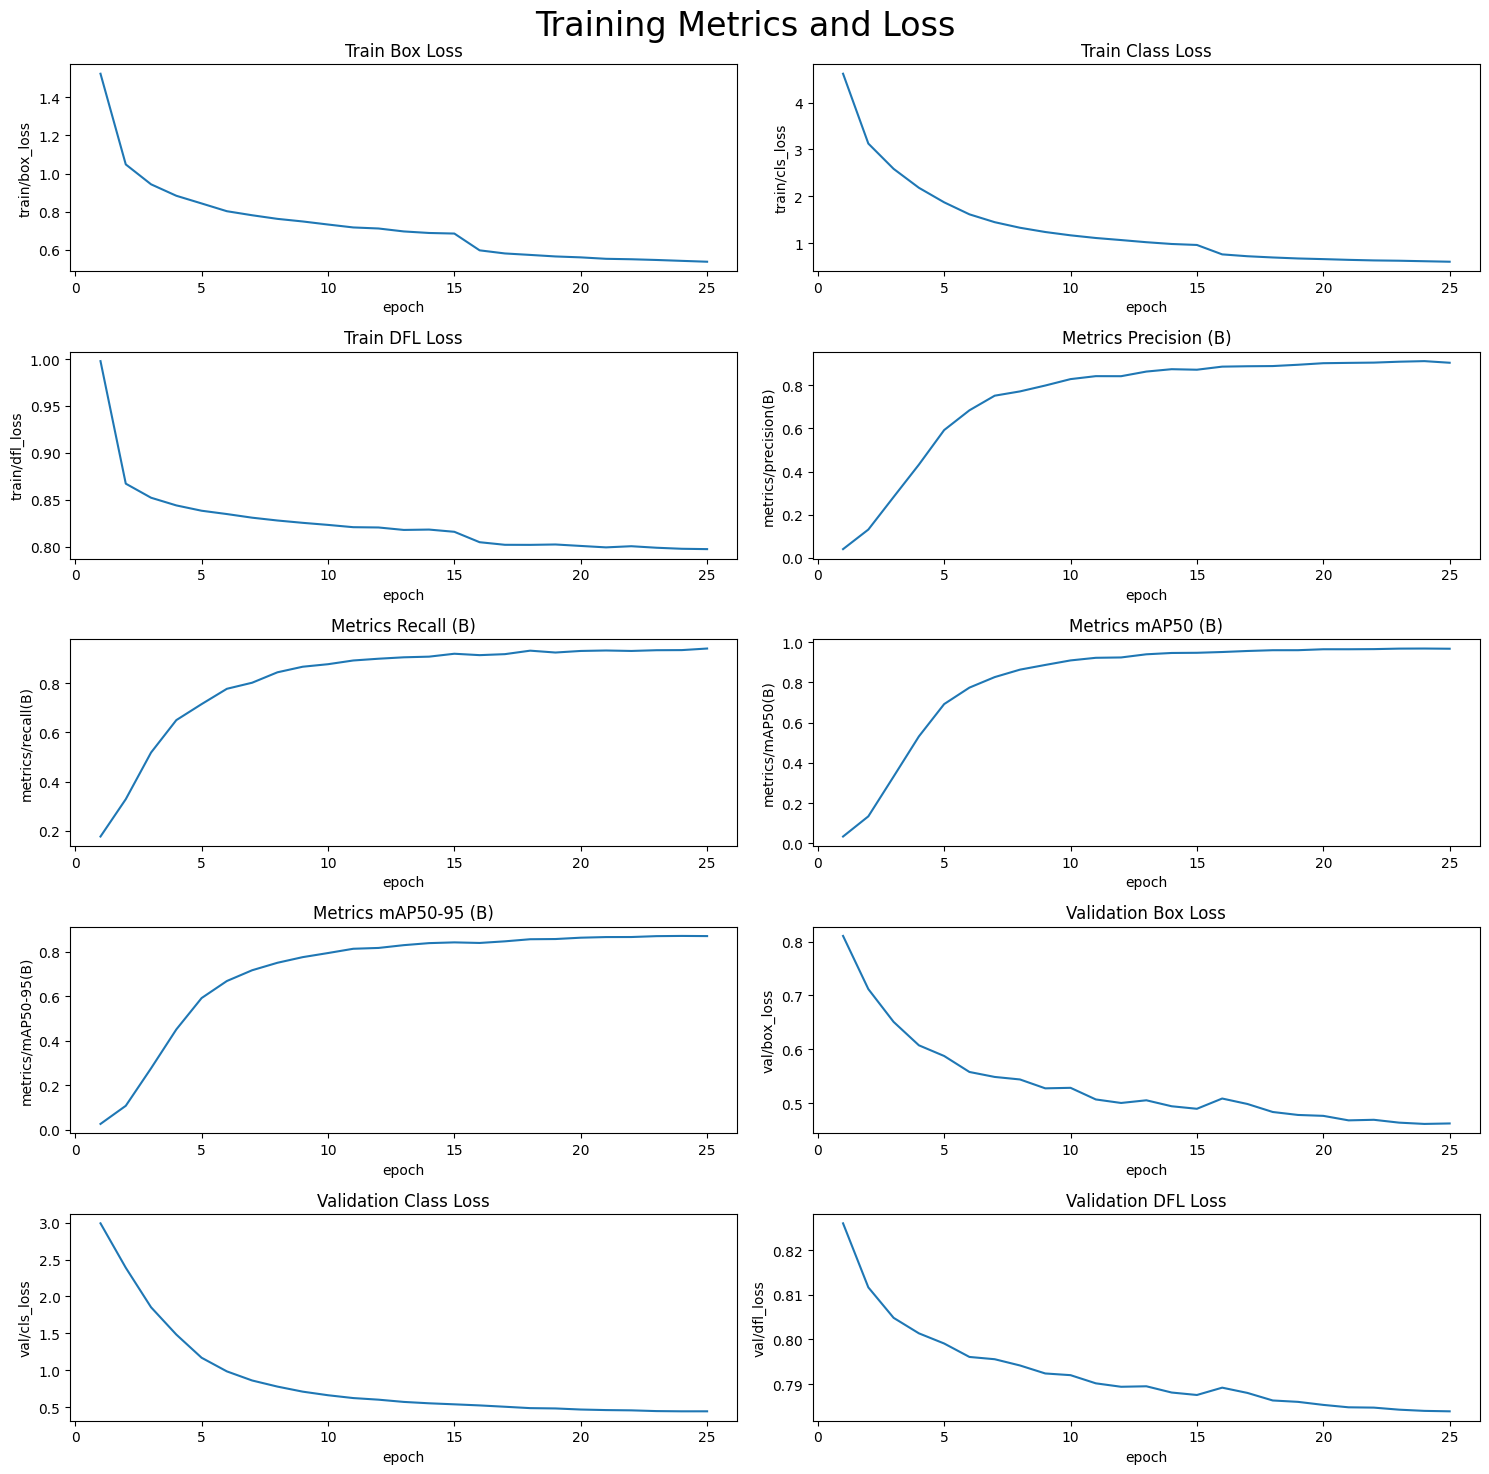

In [27]:
%matplotlib inline

# read in results as pandas dataframe
df = pd.read_csv(os.path.join(HOME, "runs/detect/yolov8n_custom/results.csv"))
df.columns = df.columns.str.strip()

# create subplots using seaborn
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15,15))

# plot the columns using seaborn
sns.lineplot(x = "epoch", y = "train/box_loss", data=df, ax=axs[0,0])
sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])

# set titles and axis labels for each subplot
axs[0,0].set(title='Train Box Loss')
axs[0,1].set(title='Train Class Loss')
axs[1,0].set(title='Train DFL Loss')
axs[1,1].set(title='Metrics Precision (B)')
axs[2,0].set(title='Metrics Recall (B)')
axs[2,1].set(title='Metrics mAP50 (B)')
axs[3,0].set(title='Metrics mAP50-95 (B)')
axs[3,1].set(title='Validation Box Loss')
axs[4,0].set(title='Validation Class Loss')
axs[4,1].set(title='Validation DFL Loss')

# add suptitle and subheader
plt.suptitle("Training Metrics and Loss", fontsize=24)

# adjust top margin to make space for suptitle
plt.subplots_adjust(top=0.93)

# adjust spacing between subplots
plt.tight_layout()

plt.show()


## 4. Evaluation

In [38]:
# laoding the best performing model
model = YOLO("runs/detect/yolov8n_custom/weights/best.pt")

# evaluating the model on test dataset
metrics = model.val(data=yaml_path, conf=0.25, split="test")

Ultralytics 8.3.82  Python-3.10.16 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
Model summary (fused): 72 layers, 3,015,788 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning C:\Users\marcu\OneDrive\Dokumenter\Programming\Python\Projects\Playing_Cards_Recognition\playing-cards-object-detection-dataset\test\labels... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:05<00:00, 374.22it/s]


val: New cache created: C:\Users\marcu\OneDrive\Dokumenter\Programming\Python\Projects\Playing_Cards_Recognition\playing-cards-object-detection-dataset\test\labels.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 125/125 [00:18<00:00,  6.88it/s]


                   all       2000       7588      0.907      0.941      0.965      0.882
                   10c         89        137      0.845      0.934      0.951      0.839
                   10d        103        170      0.882      0.947      0.973      0.859
                   10h        100        149      0.867      0.917      0.959       0.83
                   10s         96        151      0.922       0.94      0.972      0.847
                    2c         90        139      0.916      0.978      0.989      0.917
                    2d        101        158      0.918      0.968      0.986       0.91
                    2h        100        156      0.929       0.93      0.976      0.901
                    2s         95        153      0.953      0.935       0.98      0.912
                    3c         98        155      0.931      0.964      0.982      0.918
                    3d         95        143      0.963      0.914      0.968      0.891
                    3

In [40]:
print(f"Mean Average Precision @.5:.95 : {metrics.box.map}")
print(f"Mean Average Precision @ .50   : {metrics.box.map50}")
print(f"Mean Average Precision @ .70   : {metrics.box.map75}")

Mean Average Precision @.5:.95 : 0.8824907646536161
Mean Average Precision @ .50   : 0.9648532970757702
Mean Average Precision @ .70   : 0.9628008979973383


## 5. Prediction

In [41]:
def predict_detection(image_path):
    image = cv2.imread(image_path)

    detect_result = model(image)

    detect_image = detect_result[0].plot()

    detect_image = cv2.cvtColor(detect_image, cv2.COLOR_BGR2RGB)

    return detect_image

In [ ]:
image_files = sorted(os.listdir(test_images))

sample_images = random.sample(image_files)

fig, axs = plt.subplots(4, 3, figsize=(15, 20))

axs.flatten()

for i, image_file in enumerate(sample_images):

    image_path = os.path.join(test_images, image_file)
    detect_image = predict_detection(image_path)

    axs[i].imshow(detect_image)

plt.show()



In [ ]:
def visualize_images_with_annotation_boxes(image_dir, label_dir, n_images=12):
    image_files = sorted(os.listdir(image_dir))

    sample_image_files = random.sample(image_files, n_images)

    plot_ncols = 3
    plot_nrows =  (n_images + plot_ncols - 1) // plot_ncols

    fig, axs = plt.subplots(plot_nrows, plot_ncols, figsize=(15, 20))
    
    axs = axs.flatten()

    for i, image_file in enumerate(sample_image_files):
        
        image_path = os.path.join(image_dir, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_file_name = os.path.splitext(image_file)[0]
        label_path = os.path.join(label_dir, label_file_name + ".txt")

        with open(label_path, "r") as file:
            for label in file:
                class_id, x_center, y_center, width, height = map(float, label.split())
                h, w, _ = image.shape
                x_min = int((x_center - width/2) * w)
                x_max = int((x_center + width/2) * w)
                y_min = int((y_center - height/2) * h)
                y_max = int((y_center + height/2) * h)
                cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 255), 2)
                cv2.putText(image, index2label[int(class_id)], (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255, 255, 255), thickness=2)

        axs[i].imshow(image)
    
    for ax in axs: ax.axis("off")
    plt.tight_layout()
    plt.show()